# <center>**ĐỒ ÁN 2: IMAGE PROCESSING**</center>
### <center>**21127112 - Triệu Nhật Minh**</center>

### **Thư viện**

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### **0. Hiển thị danh sách ảnh**

In [58]:
def show_image(img_list):
    plt.figure(figsize=(20,15))
    size = len(img_list)
    if size == 2 or size == 3:
        [plt.subplot(1, size, i+1) and plt.imshow(img_list[i]) for i in range(size)]
    elif size == 12:
        [plt.subplot(3, 4, i+1) and plt.imshow(img_list[i]) for i in range(size)]
    plt.show()

### **1. Thay đổi độ sáng cho ảnh**

In [59]:
def limit_value(img_2d):
    return np.clip(img_2d, 0, 255, out=img_2d)

In [60]:
def change_brightness(img_2d, brightness=128):
    return limit_value(img_2d.astype('int64') + brightness).astype('uint8')

### **2. Thay đổi độ tương phản của ảnh**

In [61]:
def change_contrast(img_2d, contrast=128):
    factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
    return limit_value(factor * (img_2d.astype('float64') - 128) + 128).astype('uint8')

### **3. Lật ảnh ngang/dọc**

In [62]:
def flip_image(img_2d, axis):
    if axis == 0:
        return img_2d[::-1, :]
    elif axis == 1:
        return img_2d[:, ::-1]

### **4. RGB &rarr; grayscale, RGB &rarr; sepia**

In [63]:
def convert_grayscale(img_2d):
    gray_image = np.dot(img_2d, [0.3, 0.59, 0.11]).astype('uint8')
    return np.repeat(gray_image[...,None], img_2d.shape[-1], axis=-1)

In [64]:
def convert_sepia(img_2d):
    sepia_array = np.array([[0.393, 0.769, 0.189], [0.349, 0.686, 0.168], [0.272, 0.534, 0.131]])
    new_sepia = np.dot(img_2d, sepia_array.T)
    return limit_value(new_sepia).astype('uint8')

### **5. Làm mờ/sắc nét**

In [65]:
def convolute_2D(img_2d, kernel):
    kernel_size = kernel.shape[0]
    padding = kernel_size // 2
    
    # Initialize new image
    img_size = img_2d.shape
    new_img_2d = np.zeros(img_size).astype('float64')
    
    # Create padding with the edge values
    img_2d = np.pad(img_2d, ((padding, padding), (padding, padding), (0, 0)), 'edge')
    
    # Convolution
    for i in range(img_size[0]):
        for j in range(img_size[1]):
            for k in range(img_size[2]):
                new_img_2d[i, j, k] = img_2d[i:i+kernel_size, j:j+kernel_size, k].flatten() @ kernel.flatten()
                
    return limit_value(new_img_2d).astype('uint8')

In [66]:
def blur_image(img_2d):
    gaussian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    return convolute_2D(img_2d, gaussian_kernel)

In [67]:
def sharpen_image(img_2d):
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return convolute_2D(img_2d, sharpen_kernel)

### **6. Cắt ảnh**

In [68]:
def center_crop(img_2d, height=256, width=256):
    h, w = img_2d.shape[:2]
    x1 = (w - width) // 2
    y1 = (h - height) // 2
    y2 = y1 + height 
    x2 = x1 + width
    return img_2d[y1:y2, x1:x2]

### **7. Cắt ảnh theo khung hình tròn**

In [69]:
def circular_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)
    radius = min(center)

    Y, X = np.ogrid[:h, :w]
    mask = (X - center[1])**2 + (Y - center[0])**2 > radius**2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask] = 0
    
    return new_img_2d

### **8. Elip mask**

#### Phương trình đường elip tổng quát:

- [tham khảo](https://math.stackexchange.com/questions/426150/what-is-the-general-equation-of-the-ellipse-that-is-not-in-the-origin-and-rotate)
- [tham khảo 2](https://www.maa.org/external_archive/joma/Volume8/Kalman/General.html)

$\frac{((x-x_0)\cos \alpha + (y-y_0) \sin \alpha)^2}{a^2} + \frac{((x-x_0)\sin \alpha - (y-y_0) \cos \alpha)^2}{b^2}= 1$ 

Với:
- $\alpha$ là góc quay của đường elip so với hệ tọa độ
- $x_0, y_0$ là tọa độ tâm của đường elip

Do tính đối xứng nên ta có thể suy ra $\alpha = \frac{\pi}{4} = 45^{\circ}$ hoặc $\alpha = \frac{3\pi}{4} = 135^{\circ}$.

Khi đó phương trình elip trở thành:
$(\frac{1}{a^2} + \frac{1}{b^2})((x-x_0)^2 + (y-y_0)^2) \pm 2(\frac{1}{a^2} - \frac{1}{b^2})(x-x_0) (y-y_0) = 2$

In [70]:
def elliptical_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)

    # for 1x1 square
    a = 0.35
    b = -0.61375
    
    # for h x w square
    new_a = a * h
    new_b = b * w
    
    Y, X = np.ogrid[:h, :w]
    
    const_1 = 1 / new_a**2 + 1 / new_b**2
    const_2 = 1 / new_a**2 - 1 / new_b**2
    
    mask_l = const_1 * ((X - center[1])**2 + (Y - center[0])**2) - const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    mask_r = const_1 * ((X - center[1])**2 + (Y - center[0])**2) + const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask_l & mask_r] = 0
    
    return new_img_2d

### **Main**

In [71]:
def main():
    #img_name = input('Nhập đường dẫn ảnh: ')
    img_name = 'lena.png'
    img_2d = np.array(Image.open(img_name))
    print("""
    0. Tất cả chức năng
    1. Đổi độ sáng (mặc định: 128)
    2. Đổi độ tương phản (mặc định: 128)
    3. Lật ảnh ngang/dọc
    4. Chuyển sang ảnh xám/sepia
    5. Làm mờ/sắc nét ảnh
    6. Cắt ảnh theo kích thước (mặc định: 256x256)
    7. Cắt ảnh theo khung tròn
    8. Cắt ảnh theo khung elip
    9. Thoát
          """)
    function = int(input('Chọn chức năng: '))
    img_list = [img_2d]
    
    if function == 0:
        img_list.extend([change_brightness(img_2d), change_contrast(img_2d), flip_image(img_2d, 0), flip_image(img_2d, 1), convert_grayscale(img_2d), convert_sepia(img_2d), blur_image(img_2d), sharpen_image(img_2d), center_crop(img_2d), circular_crop(img_2d), elliptical_crop(img_2d)])
        
    elif function == 1:
        img_list.append(change_brightness(img_2d))
        
    elif function == 2:
        img_list.append(change_contrast(img_2d))
        
    elif function == 3:
        img_list.extend([flip_image(img_2d, 0, flip_image(img_2d, 1))])
        
    elif function == 4:
        img_list.extend([convert_grayscale(img_2d), convert_sepia(img_2d)])
        
    elif function == 5:
        img_list.extend([blur_image(img_2d), sharpen_image(img_2d)])
        
    elif function == 6:
        img_list.append(center_crop(img_2d))
        
    elif function == 7:
        img_list.append(circular_crop(img_2d))
        
    elif function == 8:
        img_list.append(elliptical_crop(img_2d))
        
    elif function == 9:
        print('Thoát chương trình!')
        
    else:
        print('Chức năng không hợp lệ!')
    
    show_image(img_list)


    0. Tất cả chức năng
    1. Đổi độ sáng (mặc định: 128)
    2. Đổi độ tương phản (mặc định: 128)
    3. Lật ảnh ngang/dọc
    4. Chuyển sang ảnh xám/sepia
    5. Làm mờ/sắc nét ảnh
    6. Cắt ảnh theo kích thước (mặc định: 256x256)
    7. Cắt ảnh theo khung tròn
    8. Cắt ảnh theo khung elip
    9. Thoát
          


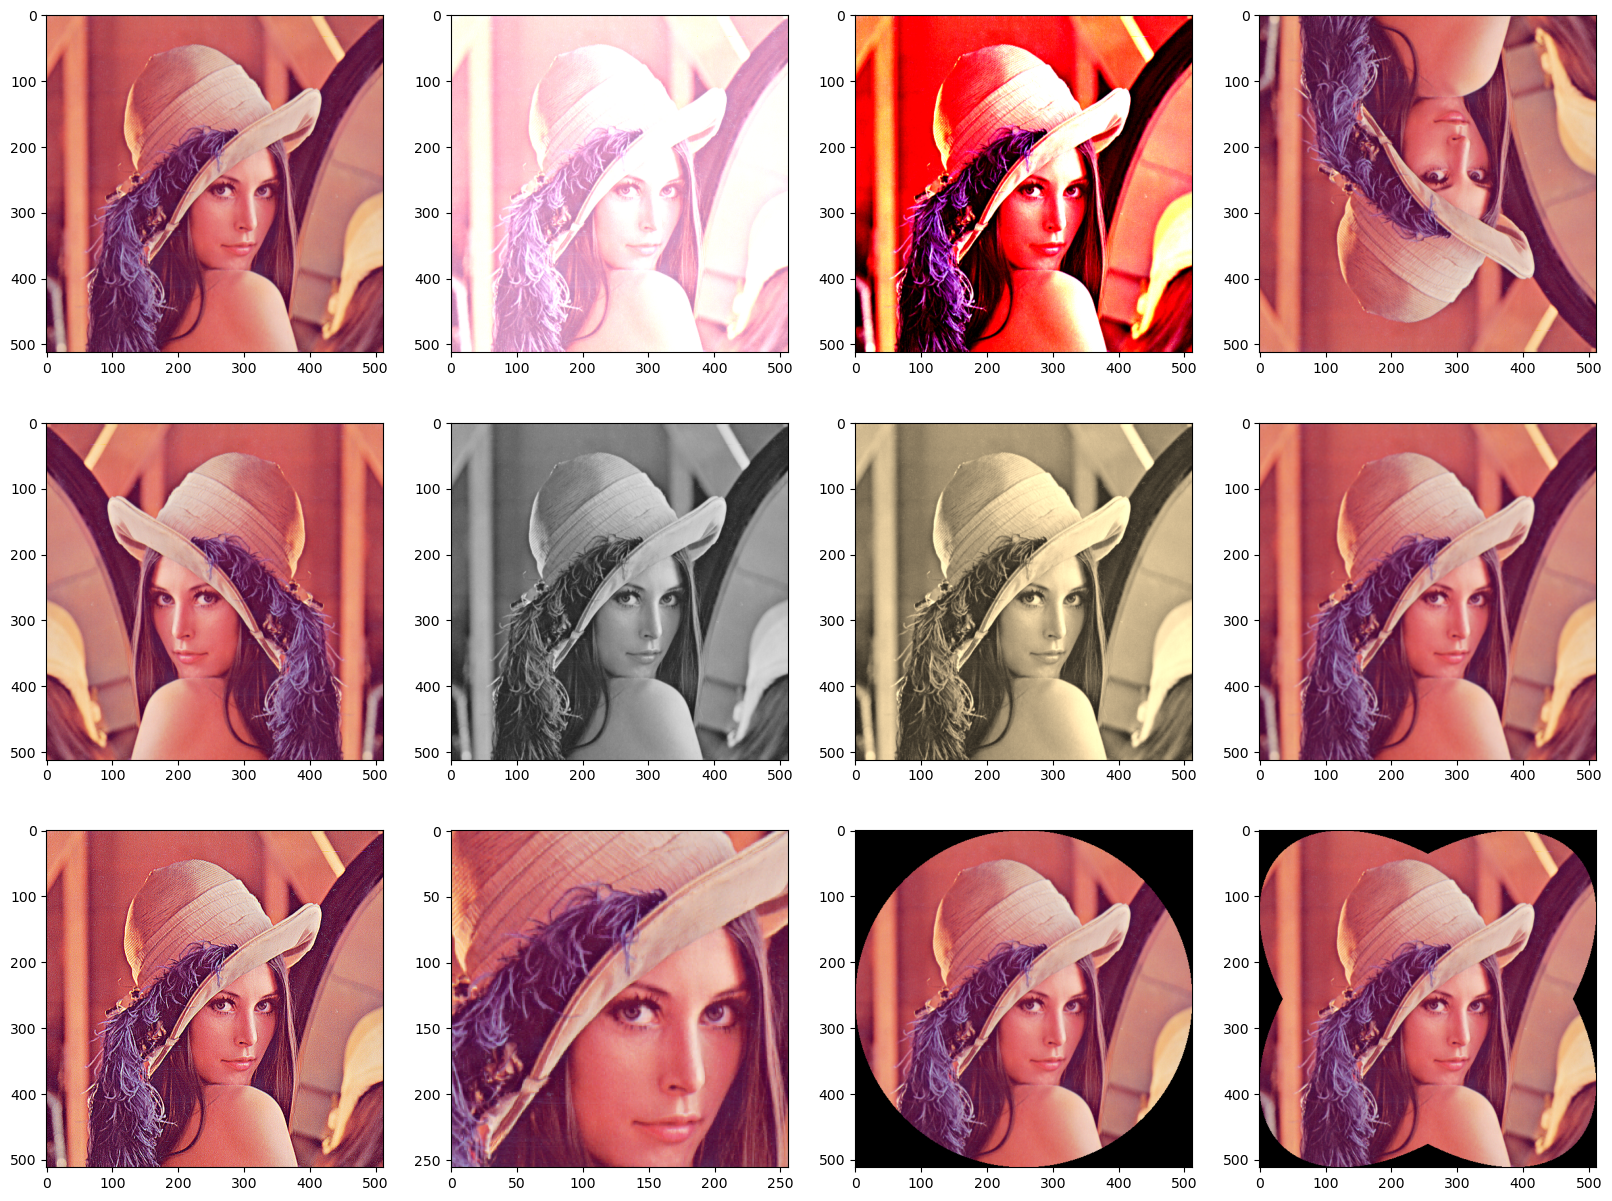

In [72]:
if __name__ == '__main__':
    main()